# Data loading

In [2]:
import sqlite3
import pandas as pd
pd.set_option('display.max_colwidth', None)
pd.options.display.float_format ='{:,.2f}'.format

In [87]:
import krisha

In [ ]:
krisha.krisha()

In [3]:
con = sqlite3.connect('old_db.db')

In [ ]:
#con = sqlite3.connect('db.db')

In [20]:
pd.read_sql('SELECT * FROM flats;', con).head(2)

,id,id_flat,uuid,url,room,square,city,lat,lon,description,photo,date,price
0,1,686141223,3850acf6-dc4f-40c0-a309-e207e20b91a8,https://krisha.kz/a/show/686141223,2,52.90,Алматы,43.24,76.89,"панельный дом, 1980 г.п., состояние: хорошее, потолки 2.8м., санузел раздельный, телефон: отдельный, интернет оптика, меблирована частично",https://photos-kr.kcdn.kz/webp/38/3850acf6-dc4f-40c0-a309-e207e20b91a8/1-full.jpg,2023-08-09,41000000
1,2,684937218,cdc5e6e6-6fa0-472e-b308-c83902db16ba,https://krisha.kz/a/show/684937218,1,57.90,Алматы,43.17,76.90,"монолитный дом, 2022 г.п., состояние: свободная планировка, потолки 2.9м., санузел раздельный, Дом введен в эксплуатацию! квартиры в клубном доме 2-3 комнатные с предчистовой отделкой свободной планировки, теплые полы, окна витражные. Подземный паркинг, Зона барбекю, терраса общего пользования, де…",https://photos-kr.kcdn.kz/webp/cd/cdc5e6e6-6fa0-472e-b308-c83902db16ba/1-full.jpg,2023-08-09,29580000


In [26]:
df = pd.read_sql('SELECT f.id_flat, f.room, f.square, f.lat, f.lon, f.description, f.price FROM flats f;', con)

In [6]:
import osmnx as ox
import pandas as pd
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
%matplotlib inline

In [7]:
place = {'city': 'Almaty', 'country': 'Kazakhstan'}
G = ox.graph_from_place(place, network_type='drive')

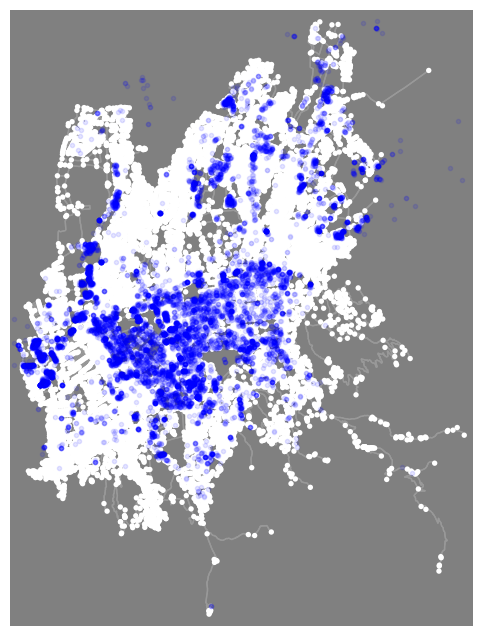

In [8]:
fig, ax = ox.plot_graph(G, show=False, close=False, bgcolor='grey')
ax.plot(df['lon'],df['lat'],'bo',alpha=0.1,markersize=3)
plt.show()

<Axes: xlabel='lon', ylabel='lat'>

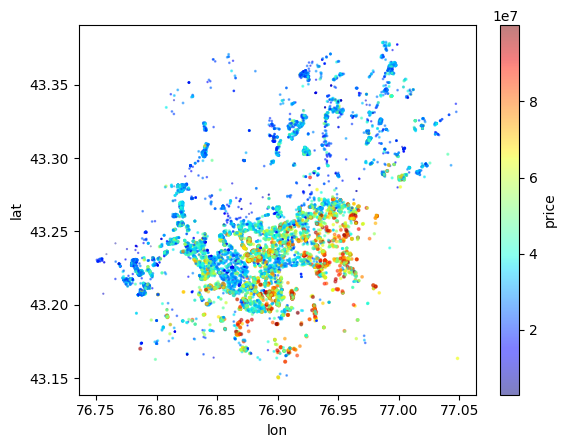

In [22]:
t = df[((df.lon>76.75)&(df.lon<77.05))&((df.lat>43.15)&(df.lat<43.38))&(df.price<10**8)]
t.plot(kind="scatter", x="lon", y="lat", alpha=0.5, s=[(i/10**8)*4 for i in t.price.values], 
             c="price", cmap=plt.get_cmap("jet"))

In [23]:
len(df)

13133

In [24]:
len(t)

12287

# Add year and type

In [27]:
pattern = '(\d{4}) г'
df['year'] = df.description.str.extract(pattern, expand=False)

In [28]:
df['year'] = df['year'].astype('int64')

In [29]:
def home_type(x):
    if 'кирпичный' in x:
        return 'кирпичный дом'
    if 'монолитный' in x:
        return 'монолитный дом'
    if 'панельный' in x:
        return 'панельный дом'
    return 'другой'

In [30]:
df['home_type'] = df['description'].apply(home_type)

In [31]:
df = df.drop(['description'], axis=1)

In [32]:
df.head()

,id_flat,room,square,lat,lon,price,year,home_type
0,686141223,2,52.90,43.24,76.89,41000000,1980,панельный дом
1,684937218,1,57.90,43.17,76.90,29580000,2022,монолитный дом
2,686513752,2,65.90,43.32,77.02,28900000,2023,монолитный дом
3,685684495,1,29.00,43.21,76.89,25000000,2023,монолитный дом
4,686240870,3,78.00,43.29,76.94,52000000,2014,монолитный дом


In [55]:
df[df.id_flat.duplicated(keep=False)]

,id_flat,room,square,lat,lon,price,year,home_type


In [15]:
df.corr()

C:\Users\adilk\AppData\Local\Temp\ipykernel_7592\1134722465.py:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  df.corr()


,room,square,lat,lon,price,year
room,1.00,0.78,-0.02,0.02,0.64,-0.07
square,0.78,1.00,-0.03,0.01,0.83,0.20
lat,-0.02,-0.03,1.00,-0.13,-0.05,-0.01
lon,0.02,0.01,-0.13,1.00,0.03,-0.02
price,0.64,0.83,-0.05,0.03,1.00,0.16
year,-0.07,0.20,-0.01,-0.02,0.16,1.00


# Training and test sample 

In [34]:
from sklearn.model_selection import train_test_split

In [35]:
train, test = train_test_split(df, random_state=42)

In [36]:
len(train)

9849

In [37]:
len(test)

3284

# Data analysis

In [38]:
train.isna().sum()

id_flat      0
room         0
square       0
lat          0
lon          0
price        0
year         0
home_type    0
dtype: int64

<Axes: >

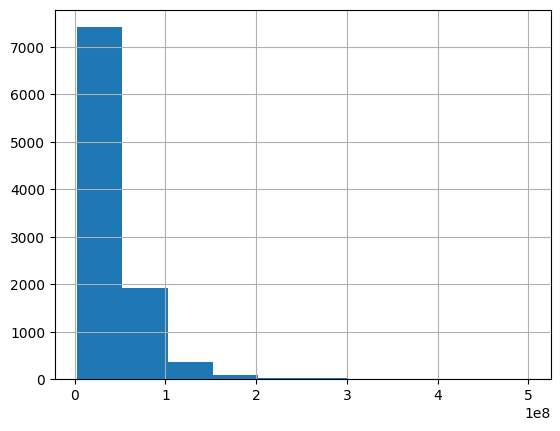

In [39]:
train['price'].hist()

In [40]:
train['price'].describe()

count         9,849.00
mean     45,348,879.18
std      34,314,890.25
min       2,990,000.00
25%      26,500,000.00
50%      36,000,000.00
75%      52,000,000.00
max     500,000,000.00
Name: price, dtype: float64

In [41]:
train.groupby('room')['price'].agg(['count','mean','median', 'min', 'max'])

,count,mean,median,min,max
room,,,,,
1,2886,"24,604,276.21","24,000,000.00",2990000,94860000
2,3586,"40,283,730.35","36,000,000.00",3900000,280000000
3,2761,"58,473,169.85","49,999,990.00",7800000,379000000
4,523,"99,731,966.49","85,000,000.00",24000000,375000000
5,68,"165,583,419.12","142,500,000.00",15000000,478500000
6,16,"207,862,500.00","186,350,000.00",47100000,378000000
7,7,"353,714,285.71","345,000,000.00",67000000,500000000
10,1,"240,000,000.00","240,000,000.00",240000000,240000000
11,1,"270,000,000.00","270,000,000.00",270000000,270000000


<Axes: xlabel='room'>

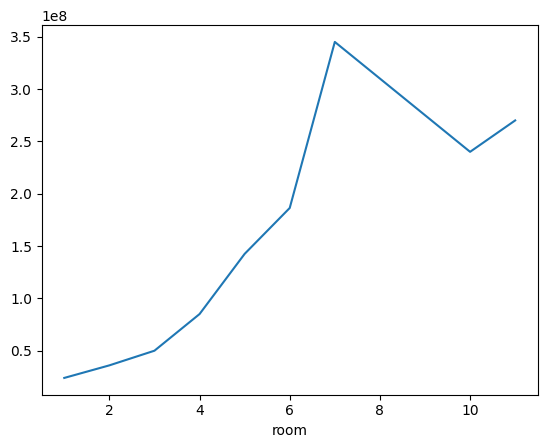

In [42]:
train.groupby('room')['price'].median().plot()

In [43]:
train['square_cut'] = pd.cut(train['square'],[0,40.0,50.0,60.0,70.0,88.0,float('inf')])

In [44]:
train.groupby('square_cut')['price'].agg(['count','mean','median'])

,count,mean,median
square_cut,,,
"(0.0, 40.0]",1973,"21,840,632.29","22,000,000.00"
"(40.0, 50.0]",1955,"30,489,479.94","28,500,000.00"
"(50.0, 60.0]",1611,"38,215,271.98","36,000,000.00"
"(60.0, 70.0]",1527,"43,876,873.38","41,000,000.00"
"(70.0, 88.0]",1376,"55,135,940.39","52,000,000.00"
"(88.0, inf]",1407,"99,154,774.36","85,500,000.00"


<Axes: xlabel='square_cut'>

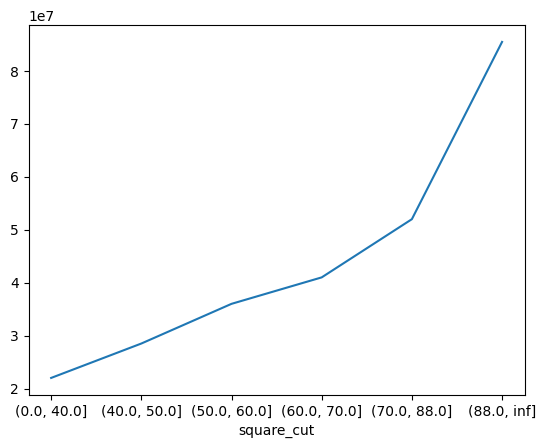

In [45]:
train.groupby('square_cut')['price'].median().plot()

In [46]:
train.groupby(pd.cut(train['year'],[-float('inf'),1980,2010,2020,2022,float('inf')]))['price'].agg(['count', 'mean','median'])

,count,mean,median
year,,,
"(-inf, 1980.0]",2075,"34,357,048.61","31,888,999.00"
"(1980.0, 2010.0]",2209,"47,759,958.30","38,500,000.00"
"(2010.0, 2020.0]",2351,"52,076,900.71","40,000,000.00"
"(2020.0, 2022.0]",1683,"48,241,108.00","38,000,000.00"
"(2022.0, inf]",1531,"43,256,635.53","35,000,000.00"


In [47]:
train[train['year']>2010].groupby('year')['price'].agg(['count', 'mean','median'])

,count,mean,median
year,,,
2011,96,"54,645,254.03","45,000,000.00"
2012,219,"55,110,070.97","45,000,000.00"
2013,156,"48,852,692.36","38,000,000.00"
2014,174,"48,166,707.45","37,000,000.00"
2015,266,"55,368,178.78","40,500,000.00"
2016,193,"63,505,512.12","45,000,000.00"
2017,259,"50,572,817.50","36,000,000.00"
2018,272,"50,257,394.07","38,950,000.00"
2019,395,"51,045,352.79","39,500,000.00"


In [48]:
train.groupby('home_type')['price'].agg(['count','mean','median'])

,count,mean,median
home_type,,,
другой,771,"48,770,564.90","34,569,500.00"
кирпичный дом,1510,"42,006,217.23","34,000,000.00"
монолитный дом,5570,"49,474,866.21","38,685,000.00"
панельный дом,1998,"35,052,358.73","34,000,000.00"


# Baseline

In [49]:
train['price_pred_mean'] = train['price'].mean()

In [50]:
train['err_abs'] = abs(train['price_pred_mean'] - train['price'])

In [51]:
train['err_abs_pct'] = train['err_abs'] / train['price']

In [52]:
train.head()

,id_flat,room,square,lat,lon,price,year,home_type,square_cut,price_pred_mean,err_abs,err_abs_pct
9187,684586727,1,30.00,43.24,76.81,16000000,2023,монолитный дом,"(0.0, 40.0]","45,348,879.18","29,348,879.18",1.83
8990,682125572,1,54.00,43.22,76.79,28000000,2022,монолитный дом,"(50.0, 60.0]","45,348,879.18","17,348,879.18",0.62
12970,685468314,1,35.00,43.21,76.79,24000000,2023,монолитный дом,"(0.0, 40.0]","45,348,879.18","21,348,879.18",0.89
10778,686715658,2,93.00,43.19,76.78,37500000,2012,монолитный дом,"(88.0, inf]","45,348,879.18","7,848,879.18",0.21
3693,686591180,1,34.80,43.25,76.86,18500000,2024,монолитный дом,"(0.0, 40.0]","45,348,879.18","26,848,879.18",1.45


In [56]:
train['err_abs'].mean()

21231039.633047193

In [57]:
train['err_abs_pct'].mean()

0.6064232654261902

In [58]:
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error

In [59]:
def error(y_true,y_pred):
    print(mean_absolute_error(y_true,y_pred))
    print(mean_absolute_percentage_error(y_true,y_pred))

In [60]:
error(train['price'], train['price_pred_mean'])

21231039.633047193
0.6064232654261902


# Algorithm based on sq. meter

In [61]:
model_square_mean = train.groupby('square_cut')['price'].mean().reset_index()

In [62]:
model_square_mean.columns = ['square_cut', 'price_pred_square_mean']

In [63]:
train = train.merge(model_square_mean,how='left',on='square_cut')

In [64]:
train.head(5)

,id_flat,room,square,lat,lon,price,year,home_type,square_cut,price_pred_mean,err_abs,err_abs_pct,price_pred_square_mean
0,684586727,1,30.00,43.24,76.81,16000000,2023,монолитный дом,"(0.0, 40.0]","45,348,879.18","29,348,879.18",1.83,"21,840,632.29"
1,682125572,1,54.00,43.22,76.79,28000000,2022,монолитный дом,"(50.0, 60.0]","45,348,879.18","17,348,879.18",0.62,"38,215,271.98"
2,685468314,1,35.00,43.21,76.79,24000000,2023,монолитный дом,"(0.0, 40.0]","45,348,879.18","21,348,879.18",0.89,"21,840,632.29"
3,686715658,2,93.00,43.19,76.78,37500000,2012,монолитный дом,"(88.0, inf]","45,348,879.18","7,848,879.18",0.21,"99,154,774.36"
4,686591180,1,34.80,43.25,76.86,18500000,2024,монолитный дом,"(0.0, 40.0]","45,348,879.18","26,848,879.18",1.45,"21,840,632.29"


In [65]:
error(train['price'], train['price_pred_square_mean'])

12870802.711920325
0.29798063582909917


In [66]:
test['square_cut'] = pd.cut(test['square'],[0,40.0,50.0,60.0,70.0,88.0,float('inf')])

In [67]:
test = test.merge(model_square_mean,how='left',on='square_cut')

In [68]:
test.isna().sum()

id_flat                   0
room                      0
square                    0
lat                       0
lon                       0
price                     0
year                      0
home_type                 0
square_cut                0
price_pred_square_mean    0
dtype: int64

In [69]:
error(test['price'], test['price_pred_square_mean'])

13208738.240349755
0.2961547062821224


# Add another variable

In [70]:
train['room2'] = train['room'].apply(lambda x: x if x < 5 else 5)
test['room2'] = test['room'].apply(lambda x: x if x < 5 else 5)

In [71]:
train.groupby(['square_cut','room2'])['price'].agg(['count', 'mean', 'median'])

count           mean         median
square_cut   room2                                     
(0.0, 40.0]  1       1835  21,495,452.04  21,700,000.00
             2        137  26,484,766.42  26,900,000.00
             3          1  19,000,000.00  19,000,000.00
             4          0            NaN            NaN
             5          0            NaN            NaN
(40.0, 50.0] 1        913  28,919,045.39  27,000,000.00
             2       1022  32,011,785.56  30,000,000.00
             3         20  24,390,000.00  22,750,000.00
             4          0            NaN            NaN
             5          0            NaN            NaN
(50.0, 60.0] 1        115  35,823,906.08  32,500,000.00
             2       1089  38,677,778.66  37,000,000.00
             3        405  37,644,328.42  36,000,000.00
             4          2  39,500,000.00  39,500,000.00
             5          0            NaN            NaN
(60.0, 70.0] 1         17  41,193,470.59  43,000,000.00
             2        875  42,872,284.99  39,000,000.00
             3        631  45,321,628.04  43,000,000.00
             4          4  47,125,000.00  44,750,000.00
             5          0            NaN            NaN
(70.0, 88.0] 1          4  42,749,999.75  28,499,999.50
             2        358  57,983,601.91  55,000,000.00
             3        883  53,763,606.44  50,000,000.00
             4        131  56,982,137.40  55,000,000.00
             5          0            NaN            NaN
(88.0, inf]  1          2  84,830,000.00  84,830,000.00
             2        105  73,538,279.80  70,000,000.00
             3        821  84,799,582.43  78,100,000.00
             4        386 115,097,560.81 100,000,000.00
             5         93 188,940,564.52 155,000,000.00

In [72]:
model_square_room_group_mean = train.groupby(['square_cut','room2'])['price'].mean().reset_index()

In [73]:
model_square_room_group_mean = model_square_room_group_mean.rename({'price':'square_room_mean'},axis=1)

In [74]:
train = train.merge(model_square_room_group_mean,how='left',on=['square_cut','room2'])

In [75]:
train.head()

,id_flat,room,square,lat,lon,price,year,home_type,square_cut,price_pred_mean,err_abs,err_abs_pct,price_pred_square_mean,room2,square_room_mean
0,684586727,1,30.00,43.24,76.81,16000000,2023,монолитный дом,"(0.0, 40.0]","45,348,879.18","29,348,879.18",1.83,"21,840,632.29",1,"21,495,452.04"
1,682125572,1,54.00,43.22,76.79,28000000,2022,монолитный дом,"(50.0, 60.0]","45,348,879.18","17,348,879.18",0.62,"38,215,271.98",1,"35,823,906.08"
2,685468314,1,35.00,43.21,76.79,24000000,2023,монолитный дом,"(0.0, 40.0]","45,348,879.18","21,348,879.18",0.89,"21,840,632.29",1,"21,495,452.04"
3,686715658,2,93.00,43.19,76.78,37500000,2012,монолитный дом,"(88.0, inf]","45,348,879.18","7,848,879.18",0.21,"99,154,774.36",2,"73,538,279.80"
4,686591180,1,34.80,43.25,76.86,18500000,2024,монолитный дом,"(0.0, 40.0]","45,348,879.18","26,848,879.18",1.45,"21,840,632.29",1,"21,495,452.04"


In [76]:
error(train['price'], train['square_room_mean'])

12228342.777500447
0.2873048708876762


In [77]:
test = test.merge(model_square_room_group_mean,how='left',on=['square_cut','room2'])

In [78]:
test.isna().sum()

id_flat                   0
room                      0
square                    0
lat                       0
lon                       0
price                     0
year                      0
home_type                 0
square_cut                0
price_pred_square_mean    0
room2                     0
square_room_mean          0
dtype: int64

In [57]:
test = test.dropna()

In [79]:
error(test['price'], test['square_room_mean'])

12343545.010626566
0.28175773704292495


# Machine learning

In [80]:
train, test = train_test_split(df,train_size=0.6,random_state=42)

In [81]:
val, test = train_test_split(test,train_size=0.5,random_state=42)

In [82]:
from catboost import CatBoostRegressor

In [83]:
X = ['room', 'square']

y = ['price']

In [84]:
model = CatBoostRegressor(eval_metric='MAPE',
                          random_seed=42,
                          verbose=50)

In [85]:
model.fit(train[X],train[y],eval_set=(val[X],val[y]))

Learning rate set to 0.070411
0:	learn: 0.5823129	test: 0.5776669	best: 0.5776669 (0)	total: 164ms	remaining: 2m 43s
50:	learn: 0.2541755	test: 0.2509861	best: 0.2509861 (50)	total: 344ms	remaining: 6.4s
100:	learn: 0.2432306	test: 0.2406402	best: 0.2406402 (100)	total: 503ms	remaining: 4.48s
150:	learn: 0.2414096	test: 0.2390814	best: 0.2390814 (150)	total: 667ms	remaining: 3.75s
200:	learn: 0.2392631	test: 0.2377778	best: 0.2377778 (200)	total: 870ms	remaining: 3.46s
250:	learn: 0.2375499	test: 0.2366912	best: 0.2366912 (250)	total: 1.05s	remaining: 3.13s
300:	learn: 0.2361884	test: 0.2361565	best: 0.2361500 (294)	total: 1.23s	remaining: 2.85s
350:	learn: 0.2350148	test: 0.2355580	best: 0.2355580 (350)	total: 1.43s	remaining: 2.64s
400:	learn: 0.2339595	test: 0.2353142	best: 0.2353141 (399)	total: 1.63s	remaining: 2.44s
450:	learn: 0.2330882	test: 0.2350540	best: 0.2350003 (443)	total: 1.81s	remaining: 2.2s
500:	learn: 0.2324584	test: 0.2350674	best: 0.2349949 (472)	total: 1.98s	rema

In [65]:
error(test['price'],model.predict(test[X]))

10517486.836751265
0.24045405090125746


In [66]:
import numpy as np
my_home = np.array([[2, 43]])
my_home

array([[ 2, 43]])

In [67]:
model.predict(my_home)

array([30651389.87514101])

In [100]:
X = ['room', 'square', 'lat', 'lon', 'year']

cat_features = ['home_type']

y = ['price']

In [101]:
model = CatBoostRegressor(eval_metric='MAPE')

In [102]:
model.fit(train[X],train[y],eval_set=(val[X],val[y]),)

Learning rate set to 0.072541
0:	learn: 0.5627991	test: 0.5622313	best: 0.5622313 (0)	total: 4.4ms	remaining: 4.39s
1:	learn: 0.5347868	test: 0.5343065	best: 0.5343065 (1)	total: 8.51ms	remaining: 4.24s
2:	learn: 0.5077513	test: 0.5069325	best: 0.5069325 (2)	total: 12.4ms	remaining: 4.13s
3:	learn: 0.4818422	test: 0.4814736	best: 0.4814736 (3)	total: 17.1ms	remaining: 4.26s
4:	learn: 0.4587346	test: 0.4586732	best: 0.4586732 (4)	total: 21.1ms	remaining: 4.2s
5:	learn: 0.4372695	test: 0.4370287	best: 0.4370287 (5)	total: 25.3ms	remaining: 4.19s
6:	learn: 0.4165953	test: 0.4168230	best: 0.4168230 (6)	total: 29.2ms	remaining: 4.14s
7:	learn: 0.3970518	test: 0.3979512	best: 0.3979512 (7)	total: 33.3ms	remaining: 4.13s
8:	learn: 0.3796569	test: 0.3810753	best: 0.3810753 (8)	total: 37.3ms	remaining: 4.1s
9:	learn: 0.3619591	test: 0.3638432	best: 0.3638432 (9)	total: 41.3ms	remaining: 4.08s
10:	learn: 0.3469843	test: 0.3491404	best: 0.3491404 (10)	total: 45.2ms	remaining: 4.06s
11:	learn: 0.3

102:	learn: 0.1364468	test: 0.1422516	best: 0.1422516 (102)	total: 394ms	remaining: 3.43s
103:	learn: 0.1364015	test: 0.1422467	best: 0.1422467 (103)	total: 398ms	remaining: 3.43s
104:	learn: 0.1360303	test: 0.1418893	best: 0.1418893 (104)	total: 402ms	remaining: 3.43s
105:	learn: 0.1357211	test: 0.1415561	best: 0.1415561 (105)	total: 406ms	remaining: 3.42s
106:	learn: 0.1354632	test: 0.1413284	best: 0.1413284 (106)	total: 410ms	remaining: 3.42s
107:	learn: 0.1354645	test: 0.1413573	best: 0.1413284 (106)	total: 414ms	remaining: 3.42s
108:	learn: 0.1352671	test: 0.1411816	best: 0.1411816 (108)	total: 418ms	remaining: 3.42s
109:	learn: 0.1351190	test: 0.1410878	best: 0.1410878 (109)	total: 422ms	remaining: 3.42s
110:	learn: 0.1350891	test: 0.1411175	best: 0.1410878 (109)	total: 426ms	remaining: 3.41s
111:	learn: 0.1347667	test: 0.1407753	best: 0.1407753 (111)	total: 430ms	remaining: 3.41s
112:	learn: 0.1347254	test: 0.1407842	best: 0.1407753 (111)	total: 434ms	remaining: 3.41s
113:	learn

207:	learn: 0.1252309	test: 0.1327240	best: 0.1327036 (204)	total: 795ms	remaining: 3.02s
208:	learn: 0.1251983	test: 0.1326889	best: 0.1326889 (208)	total: 798ms	remaining: 3.02s
209:	learn: 0.1251133	test: 0.1326273	best: 0.1326273 (209)	total: 802ms	remaining: 3.02s
210:	learn: 0.1250865	test: 0.1325982	best: 0.1325982 (210)	total: 806ms	remaining: 3.01s
211:	learn: 0.1250253	test: 0.1325445	best: 0.1325445 (211)	total: 810ms	remaining: 3.01s
212:	learn: 0.1249967	test: 0.1325259	best: 0.1325259 (212)	total: 814ms	remaining: 3.01s
213:	learn: 0.1249083	test: 0.1324946	best: 0.1324946 (213)	total: 819ms	remaining: 3.01s
214:	learn: 0.1247706	test: 0.1323742	best: 0.1323742 (214)	total: 823ms	remaining: 3s
215:	learn: 0.1247204	test: 0.1323305	best: 0.1323305 (215)	total: 827ms	remaining: 3s
216:	learn: 0.1246667	test: 0.1323176	best: 0.1323176 (216)	total: 831ms	remaining: 3s
217:	learn: 0.1246588	test: 0.1323134	best: 0.1323134 (217)	total: 835ms	remaining: 2.99s
218:	learn: 0.12458

315:	learn: 0.1197160	test: 0.1288977	best: 0.1288977 (315)	total: 1.21s	remaining: 2.61s
316:	learn: 0.1196029	test: 0.1287713	best: 0.1287713 (316)	total: 1.21s	remaining: 2.61s
317:	learn: 0.1195028	test: 0.1287358	best: 0.1287358 (317)	total: 1.22s	remaining: 2.61s
318:	learn: 0.1194726	test: 0.1286954	best: 0.1286954 (318)	total: 1.22s	remaining: 2.6s
319:	learn: 0.1194392	test: 0.1286776	best: 0.1286776 (319)	total: 1.22s	remaining: 2.6s
320:	learn: 0.1193399	test: 0.1286116	best: 0.1286116 (320)	total: 1.23s	remaining: 2.6s
321:	learn: 0.1193328	test: 0.1286111	best: 0.1286111 (321)	total: 1.23s	remaining: 2.59s
322:	learn: 0.1193292	test: 0.1286136	best: 0.1286111 (321)	total: 1.24s	remaining: 2.59s
323:	learn: 0.1193083	test: 0.1286167	best: 0.1286111 (321)	total: 1.24s	remaining: 2.58s
324:	learn: 0.1192688	test: 0.1285886	best: 0.1285886 (324)	total: 1.24s	remaining: 2.58s
325:	learn: 0.1191697	test: 0.1284484	best: 0.1284484 (325)	total: 1.25s	remaining: 2.58s
326:	learn: 0

418:	learn: 0.1162212	test: 0.1264082	best: 0.1264082 (418)	total: 1.6s	remaining: 2.22s
419:	learn: 0.1162171	test: 0.1264116	best: 0.1264082 (418)	total: 1.6s	remaining: 2.22s
420:	learn: 0.1162028	test: 0.1263847	best: 0.1263847 (420)	total: 1.61s	remaining: 2.21s
421:	learn: 0.1160181	test: 0.1262937	best: 0.1262937 (421)	total: 1.61s	remaining: 2.21s
422:	learn: 0.1159899	test: 0.1262863	best: 0.1262863 (422)	total: 1.62s	remaining: 2.21s
423:	learn: 0.1158938	test: 0.1261931	best: 0.1261931 (423)	total: 1.62s	remaining: 2.2s
424:	learn: 0.1158765	test: 0.1261756	best: 0.1261756 (424)	total: 1.63s	remaining: 2.2s
425:	learn: 0.1157551	test: 0.1261199	best: 0.1261199 (425)	total: 1.63s	remaining: 2.2s
426:	learn: 0.1157514	test: 0.1261211	best: 0.1261199 (425)	total: 1.64s	remaining: 2.19s
427:	learn: 0.1157396	test: 0.1261324	best: 0.1261199 (425)	total: 1.64s	remaining: 2.19s
428:	learn: 0.1156655	test: 0.1260648	best: 0.1260648 (428)	total: 1.64s	remaining: 2.19s
429:	learn: 0.1

542:	learn: 0.1114099	test: 0.1239422	best: 0.1239422 (542)	total: 2.2s	remaining: 1.85s
543:	learn: 0.1113240	test: 0.1239179	best: 0.1239179 (543)	total: 2.2s	remaining: 1.85s
544:	learn: 0.1112652	test: 0.1238822	best: 0.1238822 (544)	total: 2.21s	remaining: 1.84s
545:	learn: 0.1111826	test: 0.1238414	best: 0.1238414 (545)	total: 2.22s	remaining: 1.84s
546:	learn: 0.1111775	test: 0.1238341	best: 0.1238341 (546)	total: 2.22s	remaining: 1.84s
547:	learn: 0.1111727	test: 0.1238272	best: 0.1238272 (547)	total: 2.23s	remaining: 1.84s
548:	learn: 0.1111496	test: 0.1238135	best: 0.1238135 (548)	total: 2.23s	remaining: 1.83s
549:	learn: 0.1111367	test: 0.1238265	best: 0.1238135 (548)	total: 2.23s	remaining: 1.83s
550:	learn: 0.1110839	test: 0.1238004	best: 0.1238004 (550)	total: 2.24s	remaining: 1.82s
551:	learn: 0.1110713	test: 0.1237919	best: 0.1237919 (551)	total: 2.25s	remaining: 1.82s
552:	learn: 0.1109551	test: 0.1236746	best: 0.1236746 (552)	total: 2.25s	remaining: 1.82s
553:	learn: 

662:	learn: 0.1081436	test: 0.1226515	best: 0.1226476 (653)	total: 2.78s	remaining: 1.41s
663:	learn: 0.1081268	test: 0.1226479	best: 0.1226476 (653)	total: 2.79s	remaining: 1.41s
664:	learn: 0.1080851	test: 0.1226061	best: 0.1226061 (664)	total: 2.79s	remaining: 1.41s
665:	learn: 0.1080580	test: 0.1225871	best: 0.1225871 (665)	total: 2.8s	remaining: 1.4s
666:	learn: 0.1080562	test: 0.1225866	best: 0.1225866 (666)	total: 2.8s	remaining: 1.4s
667:	learn: 0.1080262	test: 0.1225663	best: 0.1225663 (667)	total: 2.81s	remaining: 1.39s
668:	learn: 0.1080095	test: 0.1225648	best: 0.1225648 (668)	total: 2.81s	remaining: 1.39s
669:	learn: 0.1079842	test: 0.1225486	best: 0.1225486 (669)	total: 2.81s	remaining: 1.39s
670:	learn: 0.1079797	test: 0.1225489	best: 0.1225486 (669)	total: 2.82s	remaining: 1.38s
671:	learn: 0.1079650	test: 0.1225543	best: 0.1225486 (669)	total: 2.82s	remaining: 1.38s
672:	learn: 0.1079385	test: 0.1225480	best: 0.1225480 (672)	total: 2.83s	remaining: 1.37s
673:	learn: 0.

795:	learn: 0.1051910	test: 0.1216214	best: 0.1215982 (788)	total: 3.36s	remaining: 862ms
796:	learn: 0.1051923	test: 0.1216226	best: 0.1215982 (788)	total: 3.37s	remaining: 858ms
797:	learn: 0.1051658	test: 0.1216102	best: 0.1215982 (788)	total: 3.37s	remaining: 854ms
798:	learn: 0.1051626	test: 0.1216075	best: 0.1215982 (788)	total: 3.38s	remaining: 850ms
799:	learn: 0.1051347	test: 0.1215990	best: 0.1215982 (788)	total: 3.38s	remaining: 846ms
800:	learn: 0.1051206	test: 0.1216003	best: 0.1215982 (788)	total: 3.39s	remaining: 842ms
801:	learn: 0.1051215	test: 0.1216017	best: 0.1215982 (788)	total: 3.39s	remaining: 837ms
802:	learn: 0.1051206	test: 0.1216022	best: 0.1215982 (788)	total: 3.4s	remaining: 833ms
803:	learn: 0.1050595	test: 0.1215866	best: 0.1215866 (803)	total: 3.4s	remaining: 829ms
804:	learn: 0.1049929	test: 0.1215548	best: 0.1215548 (804)	total: 3.4s	remaining: 825ms
805:	learn: 0.1049492	test: 0.1215173	best: 0.1215173 (805)	total: 3.41s	remaining: 820ms
806:	learn: 0

927:	learn: 0.1027414	test: 0.1210217	best: 0.1209687 (916)	total: 3.95s	remaining: 307ms
928:	learn: 0.1027152	test: 0.1210152	best: 0.1209687 (916)	total: 3.96s	remaining: 302ms
929:	learn: 0.1027050	test: 0.1210006	best: 0.1209687 (916)	total: 3.96s	remaining: 298ms
930:	learn: 0.1026743	test: 0.1209936	best: 0.1209687 (916)	total: 3.96s	remaining: 294ms
931:	learn: 0.1026399	test: 0.1209721	best: 0.1209687 (916)	total: 3.97s	remaining: 290ms
932:	learn: 0.1026053	test: 0.1209707	best: 0.1209687 (916)	total: 3.97s	remaining: 285ms
933:	learn: 0.1025817	test: 0.1209550	best: 0.1209550 (933)	total: 3.98s	remaining: 281ms
934:	learn: 0.1025739	test: 0.1209505	best: 0.1209505 (934)	total: 3.98s	remaining: 277ms
935:	learn: 0.1025274	test: 0.1209298	best: 0.1209298 (935)	total: 3.99s	remaining: 273ms
936:	learn: 0.1024880	test: 0.1209068	best: 0.1209068 (936)	total: 3.99s	remaining: 268ms
937:	learn: 0.1024880	test: 0.1209069	best: 0.1209068 (936)	total: 3.99s	remaining: 264ms
938:	learn

In [86]:
error(test['price'],model.predict(test[X]))

10858085.90613349
0.23573254144974545
